# Data project: Price elasticity of energy demand in Denmark

Imports and set magics:

In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

I want to analyse the price eleasticity of energy demand for February 2023. I use two data sets; (i) concumption data and (ii) spotprices of energy. Both data sets are measured on an hourly basis for February 2023

In [402]:
# (i) Importing data
Pric = pd.read_csv("Spotprices.csv", delimiter = ';')
Consumptio = pd.read_csv("Consumption.csv", delimiter = ';')


# (ii) Only including DK-time and spotprices in price data
Price = Pric.loc[Pric['PriceArea'] == 'DK1', :]
Price = Price.drop(columns = ['PriceArea', 'HourUTC', 'SpotPriceEUR']) 


# (ii) redefining the puncturation in price data set
Prices = Price['SpotPriceDKK'].values
puncturation = [i.replace(',', '.') for i in Prices]
SpotPrice = list(map(float, puncturation))
Price = Price.reset_index(drop=True)
Price  = pd.concat([Price, pd.DataFrame(puncturation, columns=['SpotPrice'])], axis=1)
Price = Price.drop(columns = ['SpotPriceDKK']) 


# (iii) Only including DK-time, consumer time and total consumption in consumption data
Consumption = Consumptio.loc[Consumptio['PriceArea'] == 'DK1', :]
Consumption = Consumption.drop(columns = ['PriceArea', 'HourUTC']) 


# (iv) Visualizing data
Price.head(10)

,HourDK,SpotPrice
0,2023-02-01 00:00,594.630005
1,2023-02-01 01:00,502.470001
2,2023-02-01 02:00,488.630005
3,2023-02-01 03:00,497.040009
4,2023-02-01 04:00,428.380005
5,2023-02-01 05:00,557.590027
6,2023-02-01 06:00,713.940002
7,2023-02-01 07:00,818.530029
8,2023-02-01 08:00,870.299988
9,2023-02-01 09:00,821.650024


A new political reform suggests that large industrial consumers are offered a reduction in energy tariffs if they are willing to accept temporary disconnection in high demand time spots (source: Tarifarbejdet - afrapporting fra Arbejdsgruppen, 2020). Therefore, only the industry will be analyzed:

In [403]:
# (i) Dropping every other consumer than industry
Consumption_industry = Consumption.loc[Consumption["ConsumerType_DE35"] == 350, :]

Consumption_industry.head(10)

,HourDK,ConsumerType_DE35,TotalCon
15,2023-02-01 00:00,350,47277
91,2023-02-01 01:00,350,46946
167,2023-02-01 02:00,350,46690
243,2023-02-01 03:00,350,46790
319,2023-02-01 04:00,350,48031
395,2023-02-01 05:00,350,47767
471,2023-02-01 06:00,350,51753
547,2023-02-01 07:00,350,58460
623,2023-02-01 08:00,350,61669
699,2023-02-01 09:00,350,60476


Redefining the variable HourDk from an object to a data time

In [404]:
# (i) setting the variabel HourDK from a string to an actual data time in consumption data set for industries
Consumption_industry['HourDK'] = pd.to_datetime(Consumption_industry['HourDK'])

# (ii) setting the variabel HourDK from a string to an actual data time in price data set
Price['HourDK']=pd.to_datetime(Price['HourDK'])

C:\Users\CAAL\AppData\Local\Temp\1\ipykernel_1548656\2944694464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Consumption_industry['HourDK'] = pd.to_datetime(Consumption_industry['HourDK'])


# Merge data sets

The two data sets are merged

In [405]:
# (i) Merging the two data sets
PC = pd.merge(Price, Consumption_industry, on='HourDK', how='outer')
PC = PC.drop(columns = ['ConsumerType_DE35'])
PC.head(10)

,HourDK,SpotPrice,TotalCon
0,2023-02-01 00:00:00,594.630005,47277
1,2023-02-01 01:00:00,502.470001,46946
2,2023-02-01 02:00:00,488.630005,46690
3,2023-02-01 03:00:00,497.040009,46790
4,2023-02-01 04:00:00,428.380005,48031
5,2023-02-01 05:00:00,557.590027,47767
6,2023-02-01 06:00:00,713.940002,51753
7,2023-02-01 07:00:00,818.530029,58460
8,2023-02-01 08:00:00,870.299988,61669
9,2023-02-01 09:00:00,821.650024,60476


To get an overview of the merged data set, the data set is summarized in the following:

In [406]:
# (i) running a describtion code with only to decimals
pd.options.display.float_format = '{:.0f}'.format
PC[['TotalCon', 'SpotPrice']].describe()

,TotalCon
count,648
mean,48138
std,8676
min,32499
25%,40157
50%,46762
75%,55374
max,69155


Based on the table above, the mean consumption of the industry in February 2023 is 48,138 kWh. However, the energy consumption varies heavily with the minimum consumption of 32,499 kWh to the maximum consumption of 69,155 kWh - which is 200 pct. increase of the minimum consumption. In the following analysis, the paper examines the variation through the day and week and calculates the price elasticity (February 2023). 

# Analysis

First of all, the eletricity consumption for the industry is plottet for a the first week of february

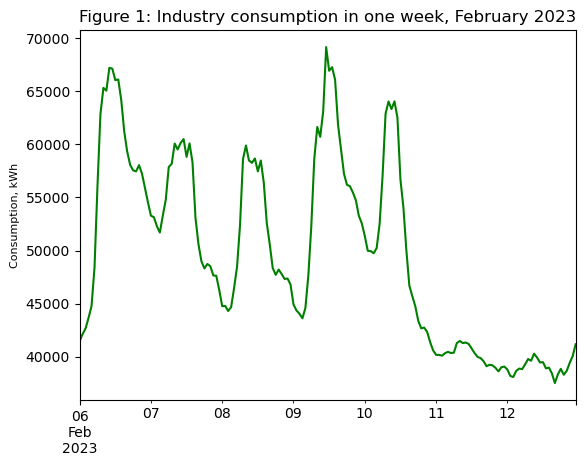

In [407]:
# (i) Creating a time interval (first week of February)
start_date = '2023-02-06 00:00:00'
end_date = '2023-02-12 23:00:00'
week_one_PC = PC.loc[(PC['HourDK']>=start_date) & (PC['HourDK'] <= end_date)]

# (ii) Creating a plot
week_one_PC.plot(y="TotalCon", x="HourDK", color='green', legend=False)

# (iii) adjusting the plot
plt.title('Figure 1: Industry consumption in one week, February 2023')
plt.xlabel('')
plt.ylabel('Consumption, kWh', fontsize=8)

# (iv) printing the plot
plt.show()

From figure 1 it is clear that the industry has high demand through the weekdays. However, the consumption drops to half during the weekend. Based on this findings, it is interesting to investigate how the energy consumption is used trough one single day:

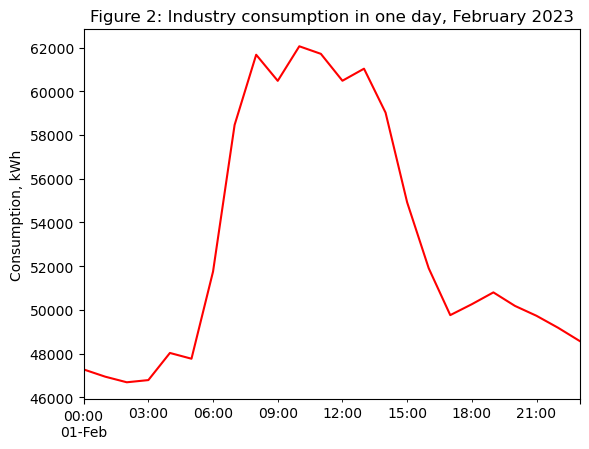

In [408]:
# (i) Creating a time interval (first day of February)
start_date = '2023-02-01 00:00:00'
end_date = '2023-02-01 23:00:00'

# (ii) Creating a plot
day_one_PC = PC.loc[(PC['HourDK']>=start_date) & (PC['HourDK'] <= end_date)]
day_one_PC.plot(y="TotalCon", x="HourDK", legend=False, color='red')

# (iii) adjusting the plot
plt.title('Figure 2: Industry consumption in one day, February 2023')
plt.xlabel('')
plt.ylabel('Consumption, kWh')

# (iv) printing the plot
plt.show()

Based on figure 2, it is clear that the pattern of energy consumption follows the work schedule - from 6 am to 5 pm through the weekdays. However, it is interesting to investigate if the price of energy affects the consumption. Therefore, the price elasticity of energy demand is calculated, but first the energy prices through the 1th of february 2023 is plotted:

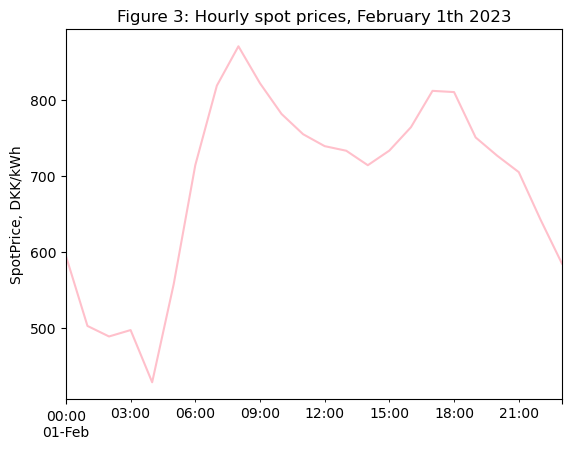

In [409]:
# (i) Creating nummerical values
PC['SpotPrice'] = pd.to_numeric(PC['SpotPrice'], errors='coerce')
PC['TotalCon'] = pd.to_numeric(PC['TotalCon'], errors='coerce')


# (i) Creating a time interval (first day of February)
start_date = '2023-02-01 00:00:00'
end_date = '2023-02-01 23:00:00'

# (ii) Creating a plot
day_one_PC = PC.loc[(PC['HourDK']>=start_date) & (PC['HourDK'] <= end_date)]
day_one_PC.plot(y="SpotPrice", x="HourDK", legend=False, color='Pink')

# (iii) adjusting the plot
plt.title('Figure 3: Hourly spot prices, February 1th 2023')
plt.xlabel('')
plt.ylabel('SpotPrice, DKK/kWh')

# (iv) printing the plot
plt.show()

Figure 3 shows how the spot prices of energy flucturate during february 1th 2023. It is relevant to notice that the spot prices are at the lowest during the night, while the opposite applies during the morning and evening. Now the price elasticity of energy demand for the industry is calculated:

In [410]:
# (i) Calculate price difference per hour
PC['Price_diff'] = PC['SpotPrice'].diff()


# (ii) Calculating the consumption difference per hour
PC['Con_diff'] = PC['TotalCon'].diff()


# (iii) Calculating the price elasticity of energy demand
PC['Price_elasticity'] = (PC['Con_diff'] / PC['TotalCon']) / (PC['Price_diff'] / PC['SpotPrice'])
pd.options.display.float_format = '{:.1f}'.format


# Output the dataframe with price difference per hour
PC.head(10)


,HourDK,SpotPrice,TotalCon,Price_diff,Con_diff,Price_elasticity
0,2023-02-01 00:00:00,594.6,47277,NaN,NaN,NaN
1,2023-02-01 01:00:00,502.5,46946,-92.2,-331.0,0.0
2,2023-02-01 02:00:00,488.6,46690,-13.8,-256.0,0.2
3,2023-02-01 03:00:00,497.0,46790,8.4,100.0,0.1
4,2023-02-01 04:00:00,428.4,48031,-68.7,1241.0,-0.2
5,2023-02-01 05:00:00,557.6,47767,129.2,-264.0,-0.0
6,2023-02-01 06:00:00,713.9,51753,156.3,3986.0,0.4
7,2023-02-01 07:00:00,818.5,58460,104.6,6707.0,0.9
8,2023-02-01 08:00:00,870.3,61669,51.8,3209.0,0.9
9,2023-02-01 09:00:00,821.7,60476,-48.6,-1193.0,0.3


Notice that the price elasticity is not above 1 for the first 10 hours of february 1th 2023. The price elasticity of demand is plotted:

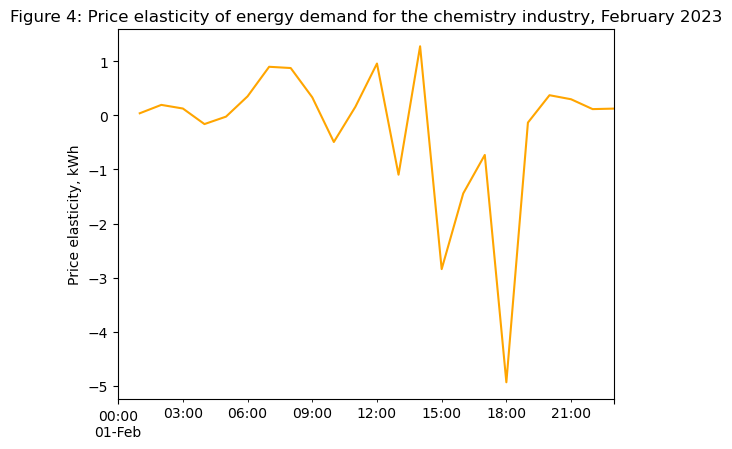

In [411]:
# (i) Creating a time interval (first day of February)
start_date = '2023-02-01 00:00:00'
end_date = '2023-02-01 23:00:00'

# (ii) Creating a plot
day_one_elas = PC.loc[(PC['HourDK']>=start_date) & (PC['HourDK'] <= end_date)]
day_one_elas.plot(y="Price_elasticity", x="HourDK", legend=False, color='orange')

# (ii) adjusting the plot
plt.title('Figure 4: Price elasticity of energy demand for the chemistry industry, February 2023')
plt.xlabel('')
plt.ylabel('Price elasticity, kWh')

# (iii) printing the plot
plt.show()

From figure 3 it is interesting to see that the price elasticity of energy demand is flucturing heavily during the day. However, it is reasonable to argue that during most of the work hours (6 am to 5 pm) the price elasticity is less than 1 indicating a very inelastic energy demand. This implies that the chemical industry is not responsive to hourly changes in prices of energy. However, it is relevant to consider a longer time period when concluding anything

# Conclusion

From the analysis, it has been shown that the chemical industry has the highest consumption of energy during the work hours (6 am to 5 pm). Unfortunately, this is also the same hours where the spot price of energy is at the highest. Figure 4 indicates that the energy demand of the chemical industry is inelastic towards price changes. However, nothing can be concluded based on this very limited analysis.